In [ ]:
import os
import zipfile
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.nn.functional as F

def load_metr_la_data():
    A = np.load("learnt_matrix.npy", allow_pickle=True).astype(np.float32)
    X = np.load("node_values3.npy", allow_pickle=True).transpose((0, 2, 1)).astype(np.float32)

    # Normalization using Z-score method
    means = np.mean(X, axis=(0, 2))
    X = X - means.reshape(1, -1, 1)
    stds = np.std(X, axis=(0, 2))
    X = X / stds.reshape(1, -1, 1)

    return A, X, means, stds

def get_normalized_adj(A):
    """
    Returns the degree normalized adjacency matrix.
    """
    A = A + np.diag(np.ones(A.shape[0], dtype=np.float32))
    D = np.array(np.sum(A, axis=1)).reshape((-1,))
    D[D <= 10e-5] = 10e-5    # Prevent infs
    diag = np.reciprocal(np.sqrt(D))
    A_wave = np.multiply(np.multiply(diag.reshape((-1, 1)), A), diag.reshape((1, -1)))
    return A_wave

def generate_dataset(X, num_timesteps_input, num_timesteps_output):
    """
    Takes node features for the graph and divides them into multiple samples
    along the time-axis by sliding a window of size (num_timesteps_input +
    num_timesteps_output) across it in steps of 1.
    :param X: Node features of shape (num_vertices, num_features, num_timesteps)
    :return:
        - Node features divided into multiple samples. Shape is
          (num_samples, num_vertices, num_features, num_timesteps_input).
        - Node targets for the samples. Shape is
          (num_samples, num_vertices, num_features, num_timesteps_output).
    """
    # Generate the beginning index and the ending index of a sample, which
    # contains (num_points_for_training + num_points_for_predicting) points
    indices = [(i, i + (num_timesteps_input + num_timesteps_output)) for i
               in range(X.shape[2] - (num_timesteps_input + num_timesteps_output) + 1)]

    # Save samples
    features, target = [], []
    for i, j in indices:
        features.append(X[:, :, i: i + num_timesteps_input].transpose((0, 2, 1)))
        target.append(X[:, 0, i + num_timesteps_input: j])
    return torch.from_numpy(np.array(features)), torch.from_numpy(np.array(target))

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F



class TimeBlock(nn.Module):
    """
    Neural network block that applies a temporal convolution to each node of
    a graph in isolation.
    """

    def __init__(self, in_channels, out_channels, kernel_size=3):
        """
        :param in_channels: Number of input features at each node in each time
        step.
        :param out_channels: Desired number of output channels at each node in
        each time step.
        :param kernel_size: Size of the 1D temporal kernel.
        """
        super(TimeBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv2 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv3 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))

    def forward(self, X):
        """
        :param X: Input data of shape (batch_size, num_nodes, num_timesteps,
        num_features=in_channels)
        :return: Output data of shape (batch_size, num_nodes,
        num_timesteps_out, num_features_out=out_channels)
        """
        # Convert into NCHW format for pytorch to perform convolutions.
        X = X.permute(0, 3, 1, 2)
        temp = self.conv1(X) + torch.sigmoid(self.conv2(X))
        out = F.relu(temp + self.conv3(X))
        # Convert back from NCHW to NHWC
        out = out.permute(0, 2, 3, 1)
        return out


class STGCNBlock(nn.Module):
    """
    Neural network block that applies a temporal convolution on each node in
    isolation, followed by a graph convolution, followed by another temporal
    convolution on each node.
    """

    def __init__(self, in_channels, spatial_channels, out_channels,
                 num_nodes):
        """
        :param in_channels: Number of input features at each node in each time
        step.
        :param spatial_channels: Number of output channels of the graph
        convolutional, spatial sub-block.
        :param out_channels: Desired number of output features at each node in
        each time step.
        :param num_nodes: Number of nodes in the graph.
        """
        super(STGCNBlock, self).__init__()
        self.temporal1 = TimeBlock(in_channels=in_channels,
                                   out_channels=out_channels)
        self.Theta1 = nn.Parameter(torch.FloatTensor(out_channels,
                                                     spatial_channels))
        self.temporal2 = TimeBlock(in_channels=spatial_channels,
                                   out_channels=out_channels)
        self.batch_norm = nn.BatchNorm2d(num_nodes)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.Theta1.shape[1])
        self.Theta1.data.uniform_(-stdv, stdv)

    def forward(self, X, A_hat):
        """
        :param X: Input data of shape (batch_size, num_nodes, num_timesteps,
        num_features=in_channels).
        :param A_hat: Normalized adjacency matrix.
        :return: Output data of shape (batch_size, num_nodes,
        num_timesteps_out, num_features=out_channels).
        """
        t = self.temporal1(X)
        lfs = torch.einsum("ij,jklm->kilm", [A_hat, t.permute(1, 0, 2, 3)])
        # t2 = F.relu(torch.einsum("ijkl,lp->ijkp", [lfs, self.Theta1]))
        t2 = F.relu(torch.matmul(lfs, self.Theta1))
        t3 = self.temporal2(t2)
        return self.batch_norm(t3)
        # return t3


class STGCN(nn.Module):
    """
    Spatio-temporal graph convolutional network as described in
    https://arxiv.org/abs/1709.04875v3 by Yu et al.
    Input should have shape (batch_size, num_nodes, num_input_time_steps,
    num_features).
    """

    def __init__(self, num_nodes, num_features, num_timesteps_input,
                 num_timesteps_output):
        """
        :param num_nodes: Number of nodes in the graph.
        :param num_features: Number of features at each node in each time step.
        :param num_timesteps_input: Number of past time steps fed into the
        network.
        :param num_timesteps_output: Desired number of future time steps
        output by the network.
        """
        super(STGCN, self).__init__()
        self.block1 = STGCNBlock(in_channels=num_features, out_channels=64,
                                 spatial_channels=16, num_nodes=num_nodes)
        self.block2 = STGCNBlock(in_channels=64, out_channels=64,
                                 spatial_channels=16, num_nodes=num_nodes)
        self.last_temporal = TimeBlock(in_channels=64, out_channels=64)
        self.fully = nn.Linear((num_timesteps_input - 2 * 5) * 64,
                               num_timesteps_output)

    def forward(self, A_hat, X):
        """
        :param X: Input data of shape (batch_size, num_nodes, num_timesteps,
        num_features=in_channels).
        :param A_hat: Normalized adjacency matrix.
        """
        out1 = self.block1(X, A_hat)
        out2 = self.block2(out1, A_hat)
        out3 = self.last_temporal(out2)
        out4 = self.fully(out3.reshape((out3.shape[0], out3.shape[1], -1)))
        return out4

In [ ]:
import os
import argparse
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

num_timesteps_input = 12
num_timesteps_output = 3

epochs = 50
batch_size = 50


def train_epoch(net,training_input, training_target, batch_size):
    """
    Trains one epoch with the given data.
    :param training_input: Training inputs of shape (num_samples, num_nodes,
    num_timesteps_train, num_features).
    :param training_target: Training targets of shape (num_samples, num_nodes,
    num_timesteps_predict).
    :param batch_size: Batch size to use during training.
    :return: Average loss for this epoch.
    """
    permutation = torch.randperm(training_input.shape[0])

    epoch_training_losses = []
    for i in range(0, training_input.shape[0], batch_size):
        net.train()
        net = net.to(device)
        optimizer.zero_grad()

        indices = permutation[i:i + batch_size]
        X_batch, y_batch = training_input[indices].to(device), training_target[indices].to(device)

        out = net(A_wave, X_batch)
        out = out.to(device)
        loss = loss_criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        epoch_training_losses.append(loss.detach().cpu().numpy())
    return sum(epoch_training_losses) / len(epoch_training_losses)


if __name__ == '__main__':
    torch.manual_seed(7)

    A, X, means, stds = load_metr_la_data()


    split_line1 = int(X.shape[2] * 0.6)
    split_line2 = int(X.shape[2] * 0.8)

    train_original_data = X[:, :, :split_line1]
    val_original_data = X[:, :, split_line1:split_line2]
    test_original_data = X[:, :, split_line2:]

    training_input, training_target = generate_dataset(train_original_data,
                                                       num_timesteps_input=num_timesteps_input,
                                                       num_timesteps_output=num_timesteps_output)
    val_input, val_target = generate_dataset(val_original_data,
                                             num_timesteps_input=num_timesteps_input,
                                             num_timesteps_output=num_timesteps_output)
    test_input, test_target = generate_dataset(test_original_data,
                                               num_timesteps_input=num_timesteps_input,
                                               num_timesteps_output=num_timesteps_output)
    training_input, training_target = training_input.to(device), training_target.to(device)
    val_input, val_target = val_input.to(device), val_target.to(device)
    test_input, test_target = test_input.to(device), test_target.to(device)
    A_wave = get_normalized_adj(A)
    A_wave = torch.from_numpy(A_wave).to(device)


    net = STGCN(A_wave.shape[0],
                training_input.shape[3],
                num_timesteps_input,
                num_timesteps_output)
    net = net.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    loss_criterion = nn.MSELoss()

    training_losses = []
    validation_losses = []
    validation_maes = []
    for epoch in range(epochs):
        loss = train_epoch(net,training_input, training_target, batch_size=batch_size)
        training_losses.append(loss)

        # Run validation
        with torch.no_grad():
            net.eval()

            out = net(A_wave, val_input)
            out = out.to(device)
            val_loss = loss_criterion(out, val_target).to(device)
            validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))

            out_unnormalized = out.detach().cpu().numpy() * stds[0] + means[0]
            target_unnormalized = val_target.detach().cpu().numpy() * stds[0] + means[0]
            mae = np.mean(np.absolute(out_unnormalized - target_unnormalized))
            validation_maes.append(mae)


            val_input = val_input.to(device)
            val_target = val_target.to(device)
            torch.save(net.to("cpu").state_dict(), f'weights1_step_{epoch+1}.pth')

        print("Training loss: {}".format(training_losses[-1]))
        print("Validation loss: {}".format(validation_losses[-1]))
        print("Validation MAE: {}".format(validation_maes[-1]))

    with torch.no_grad():
        net.eval()

    checkpoint_path = "checkpoints/"
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    with open("checkpoints/losses.pk", "wb") as fd:
        pk.dump((training_losses, validation_losses, validation_maes), fd)
    torch.save(net.to("cpu").state_dict(), 'model_state1.pth')

    plt.plot(training_losses, label="training loss")
    plt.plot(validation_losses, label="validation loss")
    plt.legend()
    plt.show()

KeyboardInterrupt: ignored

In [ ]:
def undo_z_normalization(normalized_array, means, stds):
    return (normalized_array * stds[0].reshape(1, -1, 1)) + means[0].reshape(1, -1, 1)

def mape(y_true, y_pred):
    absolute_percentage_error = torch.abs((y_true - y_pred) / y_true)
    mean_absolute_percentage_error = torch.mean(absolute_percentage_error) * 100
    return mean_absolute_percentage_error
def mae(y_true, y_pred):
    absolute_error = torch.abs(y_true - y_pred)
    mean_absolute_error = torch.mean(absolute_error)
    mae_percentage = (mean_absolute_error / torch.mean(y_true)) * 100
    return mae_percentage
def rmse(y_true, y_pred):
    squared_error = torch.pow(y_true - y_pred, 2)
    mean_squared_error = torch.mean(squared_error)
    rmse = torch.sqrt(mean_squared_error)
    rmse_percentage = (rmse / torch.mean(y_true)) * 100
    return rmse_percentage

num_timesteps_input = 12
num_timesteps_output = 3
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

NameError: ignored

In [ ]:
A, X, means, stds = load_metr_la_data()

split_line1 = int(X.shape[2] * 0.6)
split_line2 = int(X.shape[2] * 0.8)

train_original_data = X[:, :, :split_line1]
val_original_data = X[:, :, split_line1:split_line2]
test_original_data = X[:, :, split_line2:]

training_input, training_target = generate_dataset(train_original_data,
                                                   num_timesteps_input=num_timesteps_input,
                                                   num_timesteps_output=num_timesteps_output)
val_input, val_target = generate_dataset(val_original_data,
                                         num_timesteps_input=num_timesteps_input,
                                         num_timesteps_output=num_timesteps_output)
test_input, test_target = generate_dataset(test_original_data,
                                           num_timesteps_input=num_timesteps_input,
                                           num_timesteps_output=num_timesteps_output)
training_input, training_target = training_input.to(device), training_target.to(device)
val_input, val_target = val_input.to(device), val_target.to(device)
test_input, test_target = test_input.to(device), test_target.to(device)
A_wave = get_normalized_adj(A)
A_wave = torch.from_numpy(A_wave).to(device)

net = STGCN(A_wave.shape[0],
            training_input.shape[3],
            num_timesteps_input,
            num_timesteps_output)
net = net.to(device)
net.load_state_dict(torch.load(f'weights1_step_48 (1).pth'))

    # Set the model to evaluation mode
net.eval()

    # Pass the evaluation dataset through the model
with torch.no_grad():
    output = net(A_wave, test_input)
output_array = output.cpu().numpy()
test_target0 = test_target.cpu()
output_array1 = undo_z_normalization(output_array[:, :, 0], means, stds)
test_target1 = undo_z_normalization(test_target0[:, :, 0], means, stds)
mape_value = mape(test_target1, output_array1)
mae_value = mae(test_target1, output_array1)
rmse_value = rmse(test_target1, output_array1)
print(mape_value)
print(mae_value)
print(rmse_value)

NameError: ignored

In [ ]:
start_date = np.datetime64('2017-12-31 18:00:00')
increment = np.timedelta64(30, 'm')
i = 500  # Replace with your desired number of increments

result_date = start_date + i * increment

print(result_date)

NameError: ignored

In [ ]:
start_date = np.datetime64('2018-01-03T03:00:00')
end_date = np.datetime64('2018-01-11T11:00:00')

date_array = np.arange(start_date, end_date, np.timedelta64(30, 'm'))

Text(0.5, 0, 'Date')

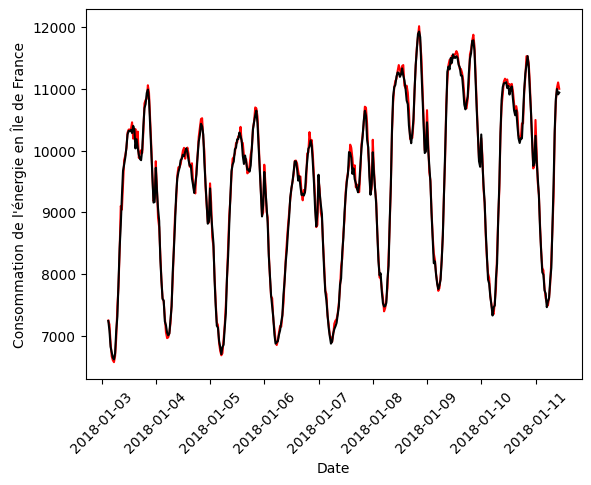

In [ ]:
plt.plot(date_array,output_array1[0,100:500,6],label="Valeurs prédites",c="r")
plt.plot(date_array,test_target1[0,100:500,6],label="Valeurs réelles",c="k")
plt.xticks(rotation=45)
plt.ylabel("Consommation de l'énergie en Île de France")
plt.xlabel('Date')